# Landmark Classification with CNN

### Designing and training a CNN from scratch

In this notebook, we will create a CNN that classifies landmarks with the main objective to attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would we have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). In Step 2 of this notebook, we will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Experiment with different architectures, hyperparameters, training strategies, and trust our intuition.  And, of course, have fun!

---
## Step 0: Setting up

In [ ]:
# Install requirements
! pip install -r requirements.txt | grep -v "already satisfied"

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## Step 1: Load Data


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


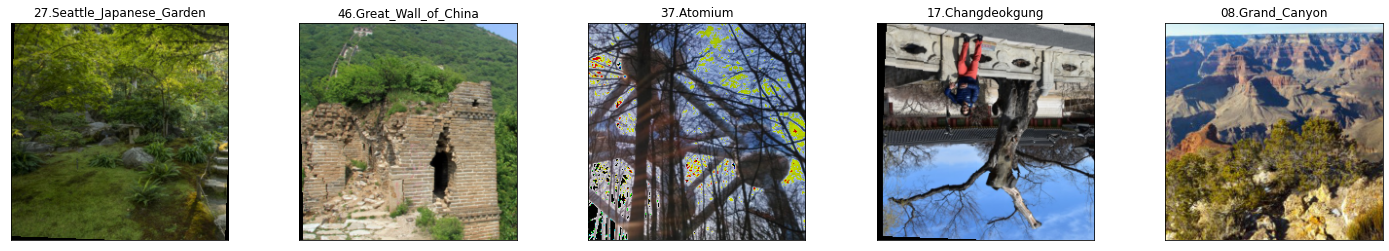

In [4]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=-1)# YOUR CODE HERE

visualize_one_batch(data_loaders)

---
## Step 2: Putting everything together

In the following cell we will train your model and validate it against the validation set.

Let's start by defining a few hyperparameters. 

In [5]:
batch_size = 32       # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2      # fraction of the training data to reserve for validation
num_epochs = 50      # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.1         # dropout for our model
learning_rate = 0.1   # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 1e-2     # regularization. Increase this to combat overfitting

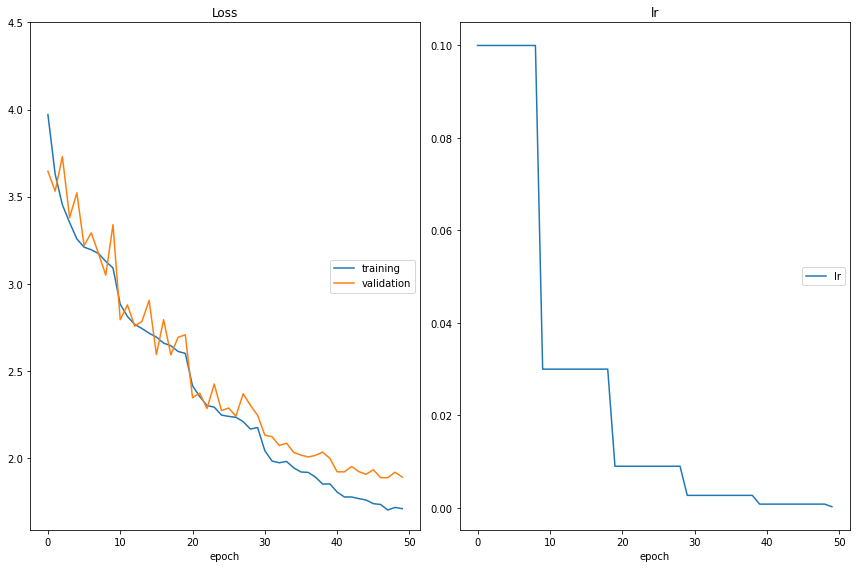

In [6]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size, num_workers=-1)# YOUR CODE HERE

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel(num_classes=num_classes, dropout=dropout)# YOUR CODE HERE

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model=model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay) # YOUR CODE HERE

# Get the loss using get_loss
loss = get_loss()# YOUR CODE HERE

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path='checkpoints/best_val_loss.pt',
    interactive_tracking=True
)

---
## Step 3: Testing against the Test Set

Run the code cell below to try out your model on the test dataset of landmark images. Ensure that your test accuracy is greater than 50%.

In [7]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:09<00:00,  4.00it/s]

Test Loss: 1.762578


Test Accuracy: 56% (703/1250)


1.762578232586384

#### Export our model using our Predictor class:

In [2]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location=torch.device('cpu')))# YOUR CODE HERE

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)# YOUR CODE HERE

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [3]:
import torch

# Load using torch.jit.load
model_reloaded =  torch.jit.load("checkpoints/original_exported.pt")# YOUR CODE HERE

In [4]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [00:42<00:00, 29.15it/s]

Accuracy: 0.568


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

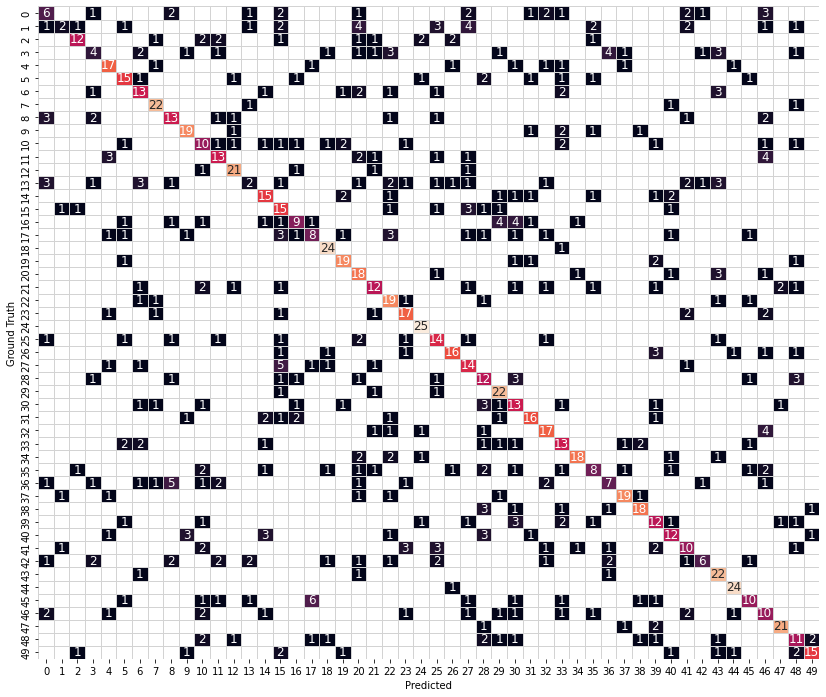

In [5]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)